In [15]:
from matplotlib import pyplot as plt

from exo_finder.compute.detrending import fit_with_wotan
from exo_finder.compute.lc_utils import split_array_in_contiguous_chunks
from exo_finder.constants import LC_WINDOW_SIZE, LC_WINDOW_MIN_SIZE
from exo_finder.default_datasets import transiting_lightcurves_ds, sunlike_lightcurves_ds
from exo_finder.visualization.lightcurve_plotting import plot_lightcurve_ax
from exotools import LightCurvePlus

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
# lc_db: LightcurveDB = get_combined_lightcurve_db()
exo_lc = transiting_lightcurves_ds.load_lightcurve_dataset()
sun_lc = sunlike_lightcurves_ds.load_lightcurve_dataset()

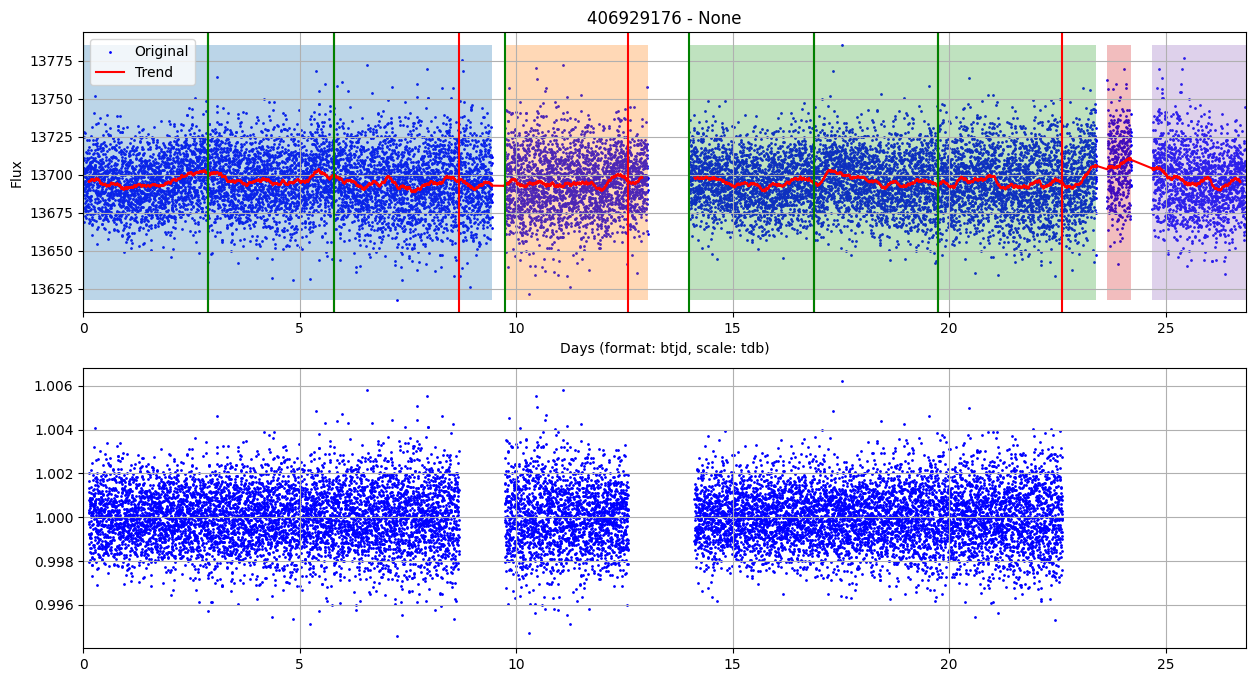

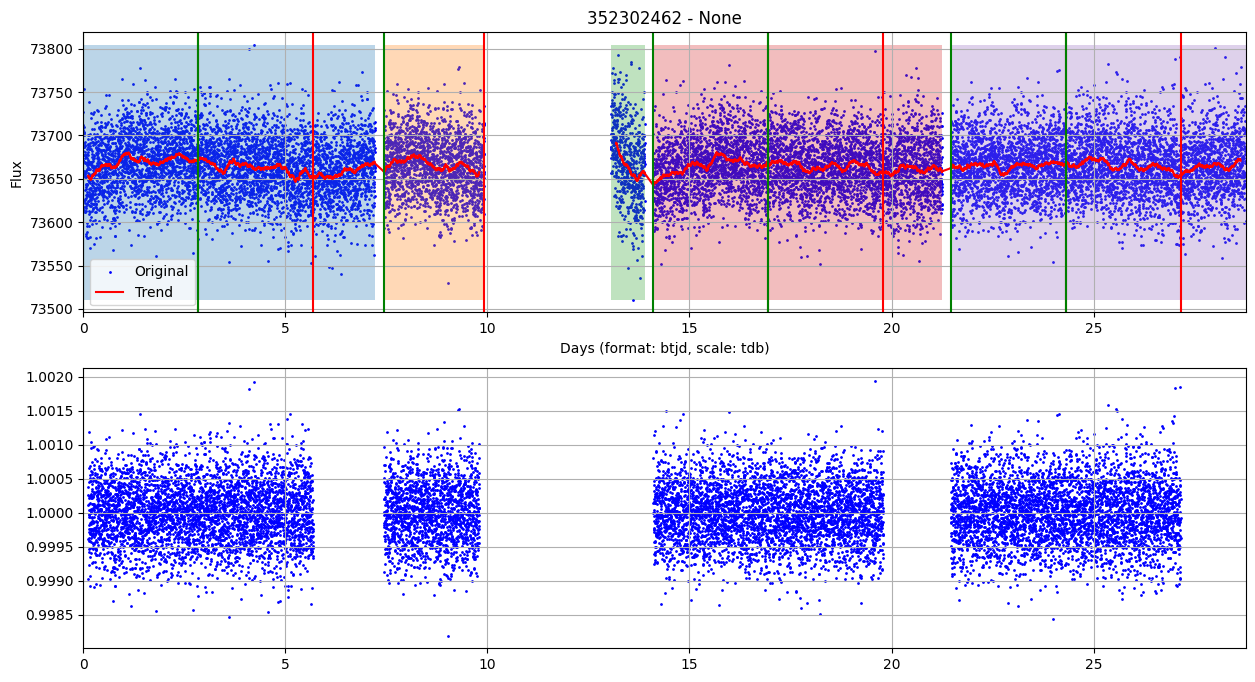

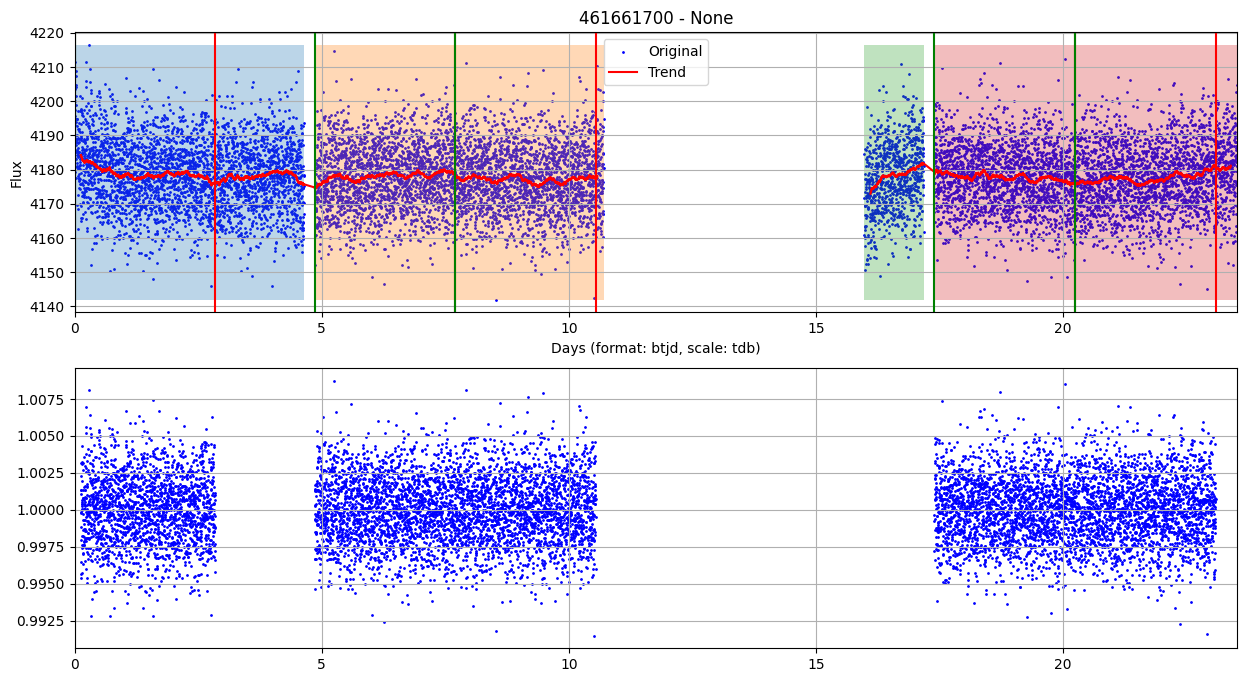

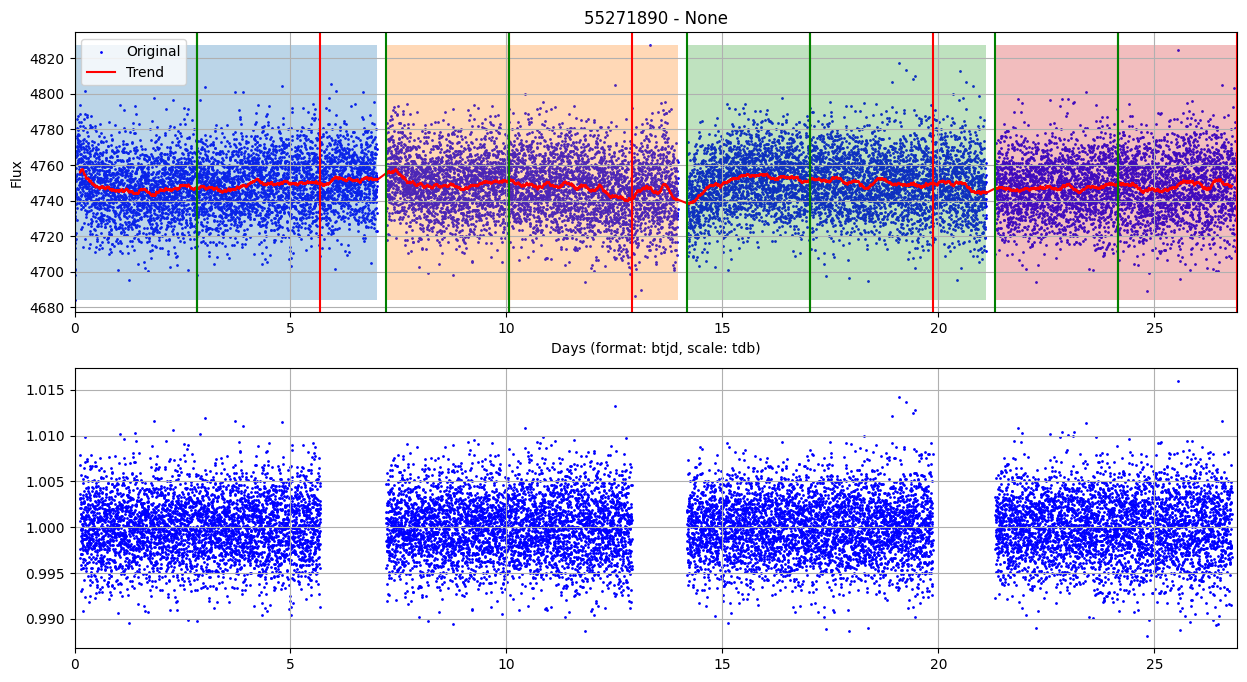

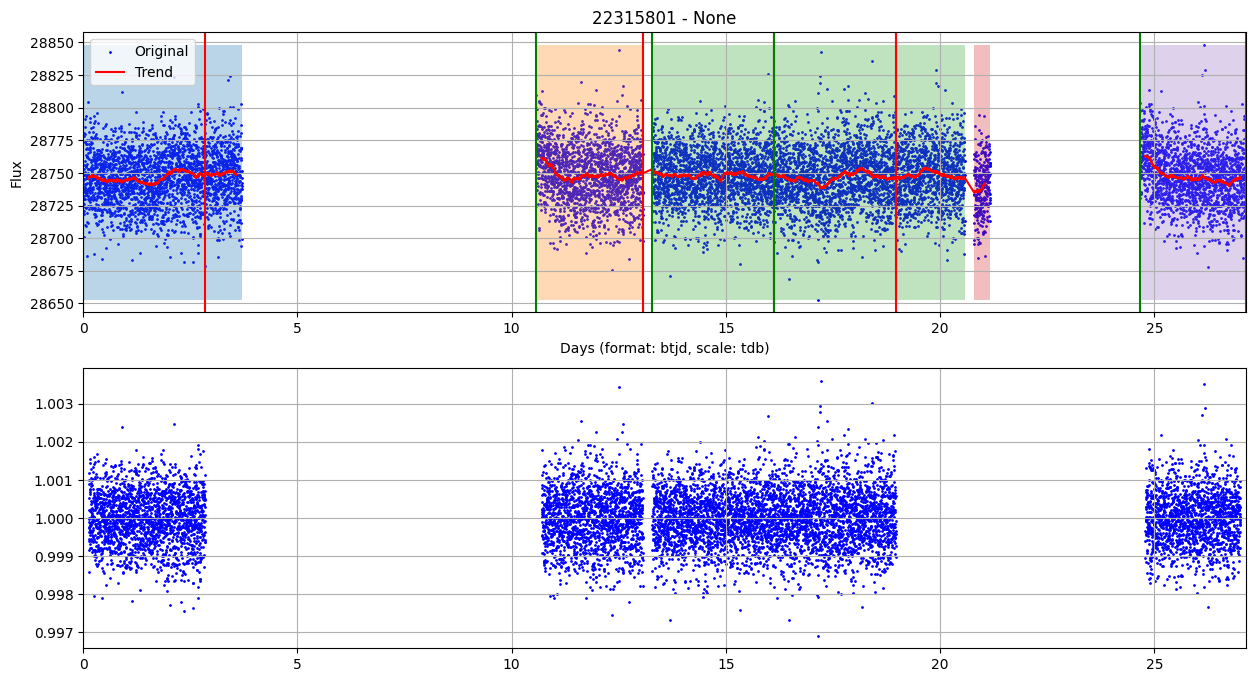

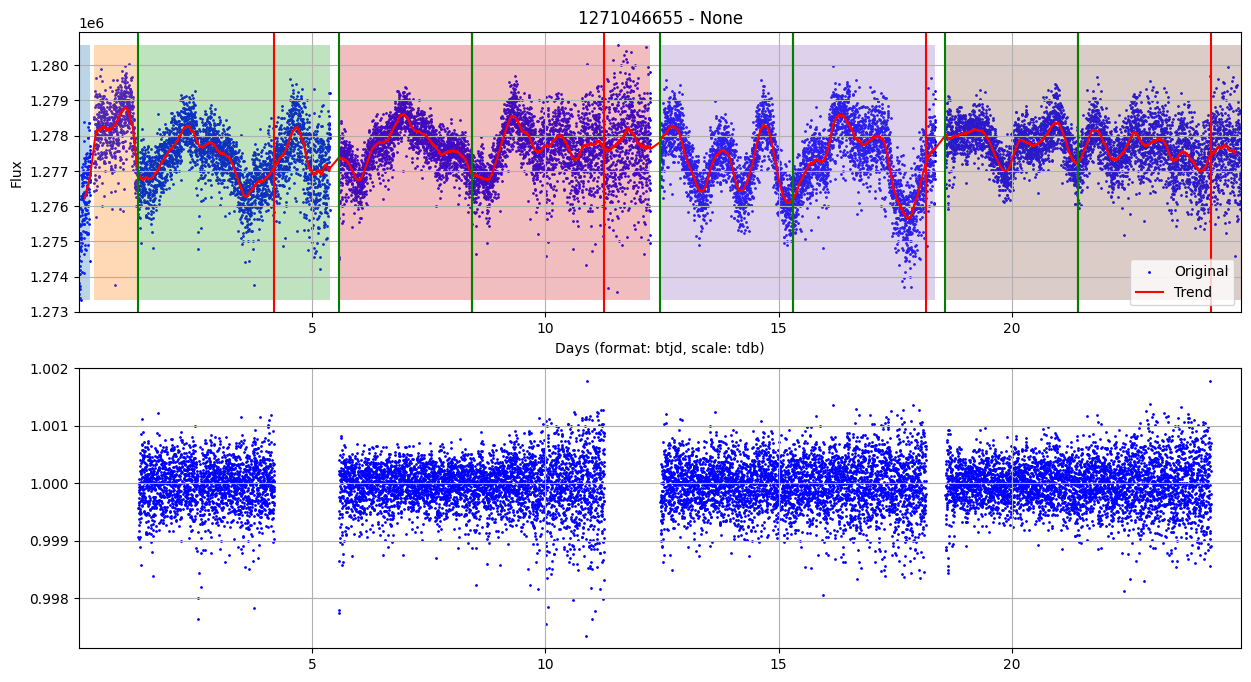

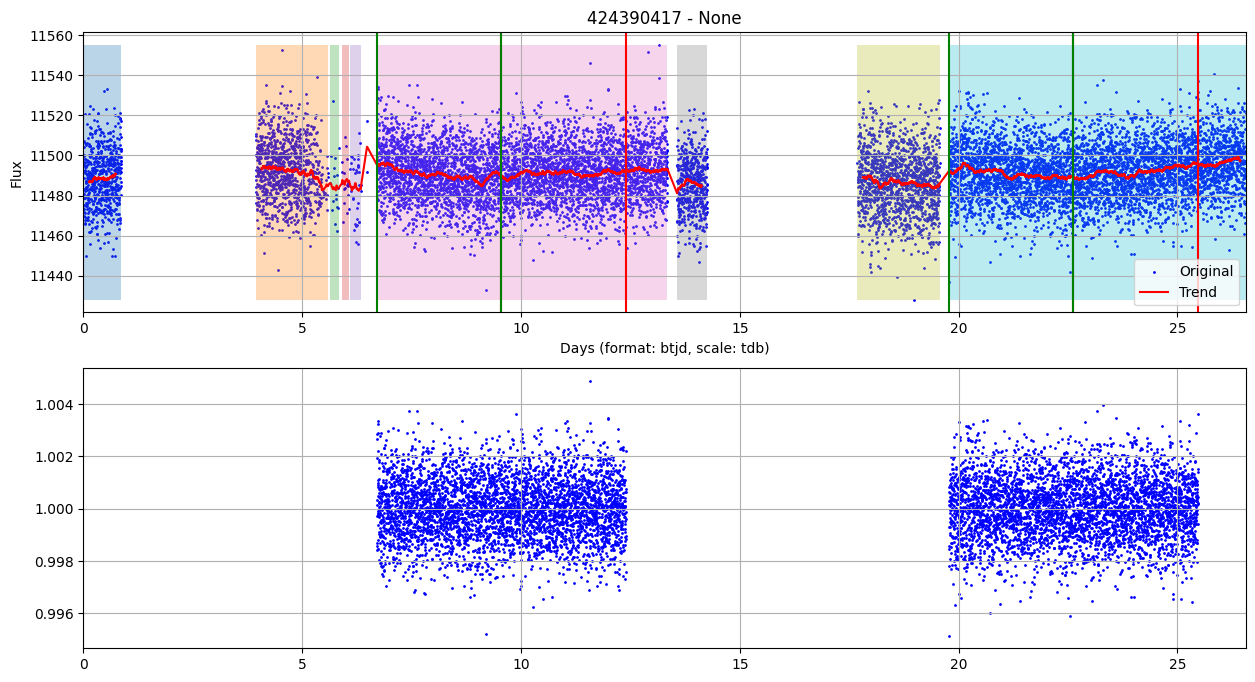

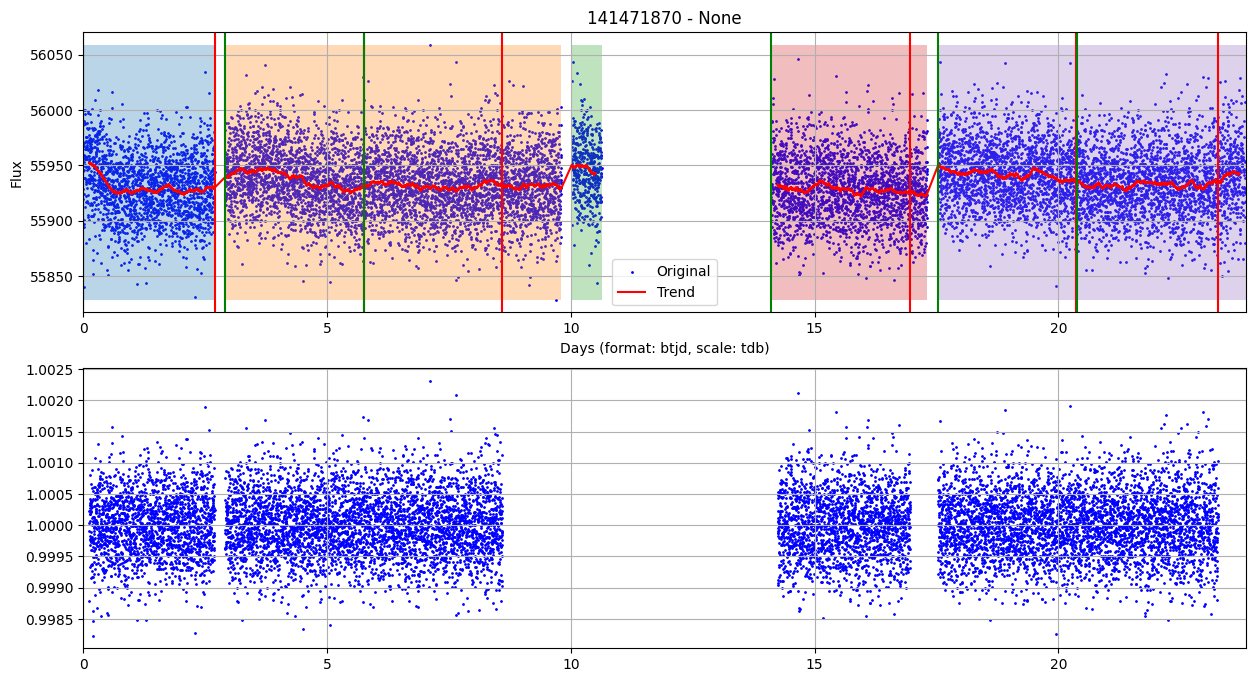

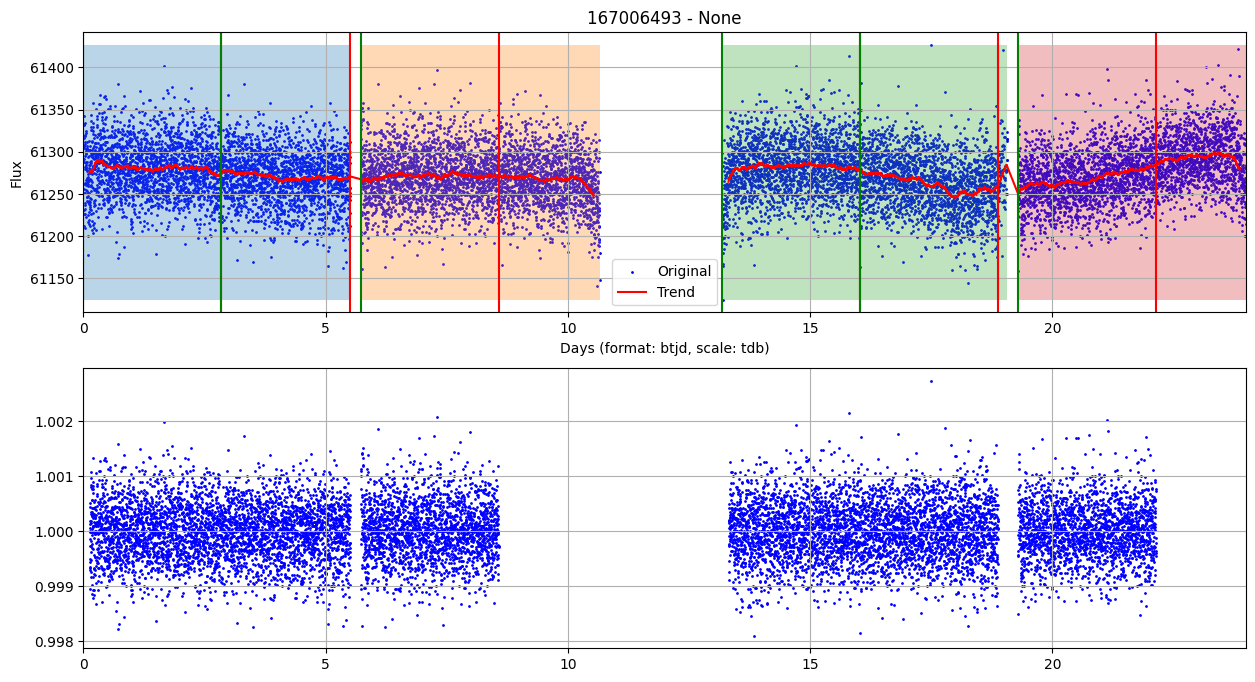

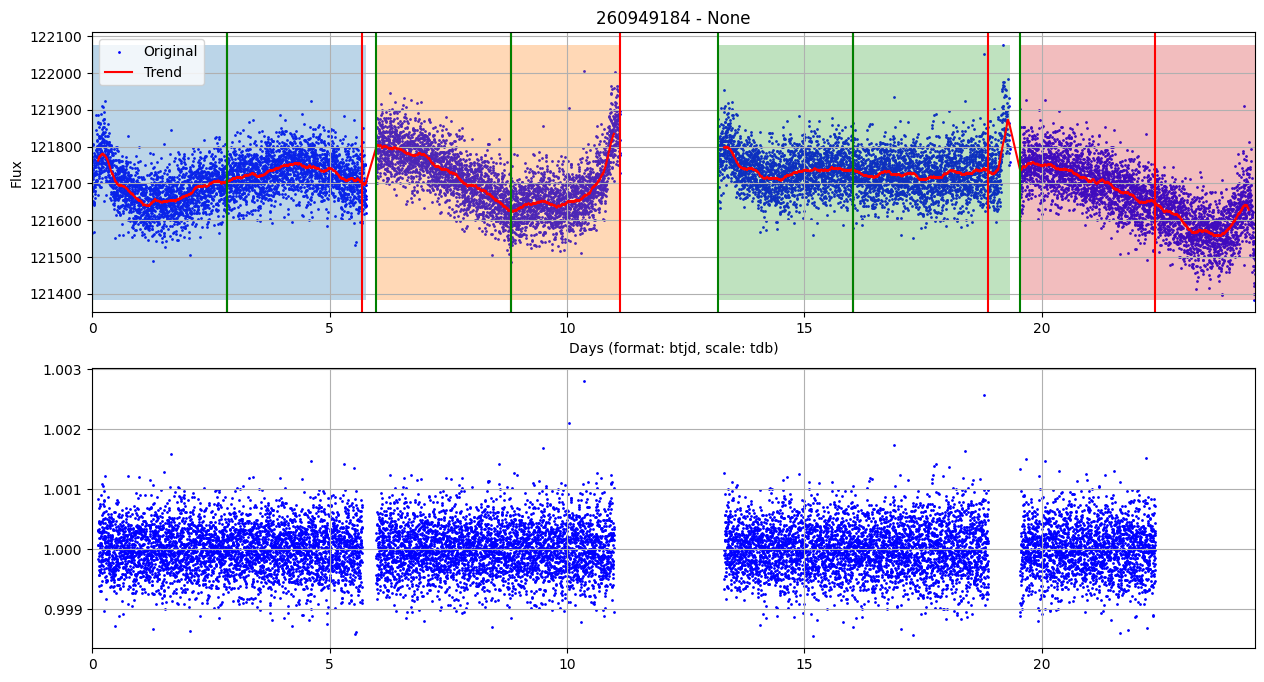

In [18]:
sample_db = sun_lc.select_random_sample(n=10)
for obs_id in sample_db.unique_obs_ids:
    lc_plus: LightCurvePlus = lc_db.load_by_obs_id(obs_id, start_time_at_zero=True).remove_outliers().remove_nans()
    fills = lc_plus.find_contiguous_time_x(greater_than_median=25)
    contiguous_intervals = split_array_in_contiguous_chunks(lc_plus.time_x, chunk_size=LC_WINDOW_SIZE, tolerate_if_len_at_least=LC_WINDOW_MIN_SIZE)
    flat_flux, trend_flux = fit_with_wotan(
        time=lc_plus.time_x,
        flux=lc_plus.flux_y,
        return_trend=True,
        window_length=0.25,
        method="biweight",
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    plot_lightcurve_ax(lightcurve=lc_plus, ax=ax1, title=f"{lc_plus.tic_id} - {lc_plus.obs_id}", label="Original")
    ax1.plot(lc_plus.time_x, trend_flux, color="red", label="Trend")

    for (fill_start, fill_end) in fills:
        ax1.fill_betweenx(y=(lc_plus.flux_y.min(), lc_plus.flux_y.max()), x1=fill_start, x2=fill_end, alpha=0.3)

    for (c_start, c_end) in contiguous_intervals:
        ax1.axvline(c_start, color="green")
        ax1.axvline(c_end, color="red")
        mask = (lc_plus.time_x >= c_start) & (lc_plus.time_x <= c_end)
        ax2.scatter(lc_plus.time_x[mask], flat_flux[mask], color="blue", s=1, label="Detrended")

    ax1.set(xlim=(lc_plus.time_x.min(), lc_plus.time_x.max()))
    ax2.set(xlim=(lc_plus.time_x.min(), lc_plus.time_x.max()))
    ax2.grid(True)
    ax1.legend()
    plt.show()